In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn import metrics
from tensorflow.keras.utils import get_file
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

def get_remote_dataset(URL,header=None):
    try:
        path = get_file(URL.split('/')[-1], origin=URL)
    except:
        print('Error downloading remote dataset.')
        raise
    return pd.read_csv(path, header=header)

def get_local_dataset(PATH, header=None):
    try:
        df = pd.read_csv(PATH,header=header)
    except:
        print('Error loading local dataset.')
        raise
    df.dropna(inplace=True,axis=1) # For now, just drop NA's (rows with missing values)
    print('Read {} rows.'.format(len(df)))
    return df

def set_KDD_columns(kdd_df):
    kdd_df.columns = [
        'duration',
        'protocol_type',
        'service',
        'flag',
        'src_bytes',
        'dst_bytes',
        'land',
        'wrong_fragment',
        'urgent',
        'hot',
        'num_failed_logins',
        'logged_in',
        'num_compromised',
        'root_shell',
        'su_attempted',
        'num_root',
        'num_file_creations',
        'num_shells',
        'num_access_files',
        'num_outbound_cmds',
        'is_host_login',
        'is_guest_login',
        'count',
        'srv_count',
        'serror_rate',
        'srv_serror_rate',
        'rerror_rate',
        'srv_rerror_rate',
        'same_srv_rate',
        'diff_srv_rate',
        'srv_diff_host_rate',
        'dst_host_count',
        'dst_host_srv_count',
        'dst_host_same_srv_rate',
        'dst_host_diff_srv_rate',
        'dst_host_same_src_port_rate',
        'dst_host_srv_diff_host_rate',
        'dst_host_serror_rate',
        'dst_host_srv_serror_rate',
        'dst_host_rerror_rate',
        'dst_host_srv_rerror_rate',
        'outcome',
        'difficulty_rating'
    ]
    #return kdd_df

def set_bin_class(df):
    for i, row in df.iterrows():
        if row['outcome'].split('.')[0] != 'normal':
            df.at[i, 'outcome'] = 'anomaly'

def set_multi_class(df):
    ### THIS WILL ONLY WORK WITH THE ENTIRE KDD DATASET. WILL NOT WORK WITH NSL-KDD SET!!! ###
    ### THIS IS YOUR ONLY WARNING!!!###
    DOS_TYPES = ('back','land','neptune','pod','smurf','teardrop')
    U2R_TYPES = ('buffer_overflow','loadmodule','perl','rootkit')
    R2L_TYPES = ('ftp_write','guess_passwd','imap','multihop','phf','spy','warezclient','warezmaster')
    PROBE_TYPES = ('ipsweep','nmap','portsweep','satan')
            
    for i, row in df.iterrows():
        val = 'normal'
        old_val = row['outcome'].split('.')[0]
        if old_val in DOS_TYPES:
            val = 'dos'
        elif old_val in U2R_TYPES:
            val = 'u2r'
        elif old_val in R2L_TYPES:
            val = 'r2l'
        elif old_val in PROBE_TYPES:
            val = 'probe'
        df.at[i,'outcome'] = val 

def encode_zscore(df, name, mean=None, std_dev=None):
    '''Encode numeric values as zscore'''
    if mean == None:
        mean = df[name].mean()
    if std_dev == None:
        std_dev = df[name].std()
    df[name] = (df[name] - mean) / std_dev

def encode_text(df, name):
    '''Encode text values to binary dummy values (i.e. red,blue is [0,1] or [1,0])'''
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        new_name = f"{name}-{x}"
        df[new_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

def reencode_dataset(df):
    '''Takes a KDD pandas dataframe and transforms the data by 
    changing numeric columns to zscore, and text columns to 
    dummy values'''

    encode_zscore(df, 'duration')
    encode_text(df, 'protocol_type')
    encode_text(df, 'service')
    encode_text(df, 'flag')
    encode_zscore(df, 'src_bytes')
    encode_zscore(df, 'dst_bytes')
    encode_text(df, 'land')
    encode_zscore(df, 'wrong_fragment')
    encode_zscore(df, 'urgent')
    encode_zscore(df, 'hot')
    encode_zscore(df, 'num_failed_logins')
    encode_text(df, 'logged_in')
    encode_zscore(df, 'num_compromised')
    encode_zscore(df, 'root_shell')
    encode_zscore(df, 'su_attempted')
    encode_zscore(df, 'num_root')
    encode_zscore(df, 'num_file_creations')
    encode_zscore(df, 'num_shells')
    encode_zscore(df, 'num_access_files')
    encode_zscore(df, 'num_outbound_cmds')
    encode_text(df, 'is_host_login')
    encode_text(df, 'is_guest_login')
    encode_zscore(df, 'count')
    encode_zscore(df, 'srv_count')
    encode_zscore(df, 'serror_rate')
    encode_zscore(df, 'srv_serror_rate')
    encode_zscore(df, 'rerror_rate')
    encode_zscore(df, 'srv_rerror_rate')
    encode_zscore(df, 'same_srv_rate')
    encode_zscore(df, 'diff_srv_rate')
    encode_zscore(df, 'srv_diff_host_rate')
    encode_zscore(df, 'dst_host_count')
    encode_zscore(df, 'dst_host_srv_count')
    encode_zscore(df, 'dst_host_same_srv_rate')
    encode_zscore(df, 'dst_host_diff_srv_rate')
    encode_zscore(df, 'dst_host_same_src_port_rate')
    encode_zscore(df, 'dst_host_srv_diff_host_rate')
    encode_zscore(df, 'dst_host_serror_rate')
    encode_zscore(df, 'dst_host_srv_serror_rate')
    encode_zscore(df, 'dst_host_rerror_rate')
    encode_zscore(df, 'dst_host_srv_rerror_rate')

    #return df

def generate_training_set(df, num_outcomes,frac=0.1):
    '''This doesn't work well right now. FIX ME!!!'''
    while True:
        df_train = df.sample(frac=frac, replace=False)
        dummies = pd.get_dummies(df_train['outcome'])
        if len(dummies.columns) != num_outcomes:
            continue
        x_columns = df_train.columns.drop(['outcome','difficulty_rating'])
        x = df_train[x_columns].values
        y = dummies.values
        break

    print(df_train.groupby('outcome')['outcome'].count())
    print(df_train.head())
    print(df_train.columns)

    return x, y

def build_classifier(x, y, hidden_layers=[8], activation='relu', batch_size=None, verbose=1):
    def baseline_model():
        model = Sequential()
        for layer in hidden_layers:
            model.add(Dense(layer, activation=activation))
        model.add(Dense(y.shape[1], activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model
    estimator = KerasClassifier(build_fn=baseline_model, batch_size=batch_size, verbose=verbose)
    return estimator

def run_tf():
    ###acquire and process dataset
    df = get_local_dataset('./nslkdd/KDDTest+.txt')
    #df_train = get_local_dataset('./nslkdd/KDDTrain+.txt')
    set_KDD_columns(df)
    reencode_dataset(df)
    #set_bin_class(df)
    df.dropna(inplace=True, axis=1)
    x, y = generate_training_set(df,df['outcome'].nunique(),frac=1.0)

    ###build MLP model
    estimator = build_classifier(x, y, hidden_layers=[64,64])
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

    ###train model
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    estimator.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=1,epochs=100)

    ###evaluate model
    pred = estimator.predict(x_test)
    y_eval = np.argmax(y_test, axis=1)
    print(y_eval)
    score = metrics.accuracy_score(y_eval, pred)
    print("Validation score: {}".format(score))

def run_tf_full():
    df_test = get_local_dataset('./nslkdd/KDDTest+.txt')
    set_KDD_columns(df_test)
    reencode_dataset(df_test)
    set_bin_class(df_test)
    for col in ('service-aol','service-harvest','service-http_2784','service-http_8001','service-red_i','service-urh_i'):
        df_test[col] = 0    
    df_test.fillna(value=0, inplace=True, axis=1)

    x_final, y_final = generate_training_set(df_test, df_test['outcome'].nunique(), frac=1.0)
    
    df_train = get_local_dataset('./nslkdd/KDDTrain+.txt')
    set_KDD_columns(df_train)
    reencode_dataset(df_train)
    set_bin_class(df_train)
    df_train.fillna(value=0, inplace=True, axis=1)

    df_test = df_test[df_train.columns] #fixes column ordering (does that matter? probably)
    #print(df_test.columns)
    #print(df_train.columns)
    
    x, y = generate_training_set(df_train, df_train['outcome'].nunique(), frac=0.1)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)


    #for col in df_train.columns:
    #    if col not in df_test.columns:
    #        print(col)

    estimator = build_classifier(x_train, y_train, hidden_layers=[128,128,128,128,128,128,128,128,128,128])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
    
    estimator.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=1,epochs=100)

    ###evaluate model
    pred = estimator.predict(x_final)
    y_eval = np.argmax(y_final, axis=1)
    print(y_eval)
    score = metrics.accuracy_score(y_eval, pred)
    print("Validation score: {}".format(score))

def run_sklearn():
    df = get_local_dataset('./nslkdd/KDDTrain+.txt')
    df = set_KDD_columns(df)
    df = reencode_dataset(df)
    df.dropna(inplace=True, axis=1)
    x, y = generate_training_set(df,df['outcome'].nunique())

    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25, random_state=42)

    mlp = MLPClassifier(hidden_layer_sizes=(64,64,),max_iter=50,verbose=True)
    mlp.fit(x_train, y_train)

    predictions = mlp.predict(x_test)
    #print(confusion_matrix(y_test, predictions))
    print(classification_report(y_test,predictions))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [88]:
from sklearn.cluster import KMeans

df = get_local_dataset('./nslkdd/KDDTrain+.txt')
print(len(df))
complete_df = df
set_KDD_columns(df)
#set_bin_class(df)
control = df
reencode_dataset(df)

df.dropna(inplace=True, axis=1)

x, y = generate_training_set(df,df['outcome'].nunique(), frac=1.0)

#model = KMeans().fit(x)


Read 125973 rows.
125973
outcome
back                 956
buffer_overflow       30
ftp_write              8
guess_passwd          53
imap                  11
ipsweep             3599
land                  18
loadmodule             9
multihop               7
neptune            41214
nmap                1493
normal             67343
perl                   3
phf                    4
pod                  201
portsweep           2931
rootkit               10
satan               3633
smurf               2646
spy                    2
teardrop             892
warezclient          890
warezmaster           20
Name: outcome, dtype: int64
        duration  src_bytes  dst_bytes  wrong_fragment    urgent       hot  \
88854  -0.110249  -0.007717   0.001181       -0.089486 -0.007736 -0.095075   
41716  -0.110249  -0.007762  -0.003672       -0.089486 -0.007736 -0.095075   
45717  -0.110249  -0.007762  -0.004919       -0.089486 -0.007736 -0.095075   
107119 -0.110249  -0.007598  -0.004919       -0.0894

In [ ]:
import seaborn as sns
sns.set(style='ticks')

fig = sns.pairplot(df, vars = [], hue='outcome', height=2, aspect=1, dropna=True)

In [3]:
df.describe()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_host_login-1,is_guest_login-0,is_guest_login-1
count,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,-2.098242e-17,-6.768524e-19,-8.460655e-19,-1.607524e-18,-7.332568e-19,4.444664e-17,-1.917748e-17,3.384262e-18,6.712120e-18,3.102240e-18,...,0.594929,0.002151,0.999802,0.000198,0.604264,0.395736,0.999992,0.000008,0.990577,0.009423
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.490908,0.046332,0.014086,0.014086,0.489010,0.489010,0.002817,0.002817,0.096612,0.096612
min,-1.102488e-01,-7.762210e-03,-4.918625e-03,-8.948607e-02,-7.735954e-03,-9.507529e-02,-2.702271e-02,-1.166360e-02,-3.665172e-02,-2.443641e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.102488e-01,-7.762210e-03,-4.918625e-03,-8.948607e-02,-7.735954e-03,-9.507529e-02,-2.702271e-02,-1.166360e-02,-3.665172e-02,-2.443641e-02,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,-1.102488e-01,-7.754715e-03,-4.918625e-03,-8.948607e-02,-7.735954e-03,-9.507529e-02,-2.702271e-02,-1.166360e-02,-3.665172e-02,-2.443641e-02,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,-1.102488e-01,-7.715194e-03,-4.790307e-03,-8.948607e-02,-7.735954e-03,-9.507529e-02,-2.702271e-02,-1.166360e-02,-3.665172e-02,-2.443641e-02,...,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,1.636422e+01,2.350665e+02,3.257473e+02,1.174343e+01,2.088183e+02,3.571940e+01,1.104967e+02,3.123677e+02,2.728363e+01,4.426805e+01,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
y[3553]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=uint8)

In [20]:
pd.set_option('display.max_rows', 200)
print(df.dtypes)

duration                       float64
src_bytes                      float64
dst_bytes                      float64
wrong_fragment                 float64
urgent                         float64
hot                            float64
num_failed_logins              float64
num_compromised                float64
root_shell                     float64
su_attempted                   float64
num_root                       float64
num_file_creations             float64
num_shells                     float64
num_access_files               float64
count                          float64
srv_count                      float64
serror_rate                    float64
srv_serror_rate                float64
rerror_rate                    float64
srv_rerror_rate                float64
same_srv_rate                  float64
diff_srv_rate                  float64
srv_diff_host_rate             float64
dst_host_count                 float64
dst_host_srv_count             float64
dst_host_same_srv_rate   

In [89]:
from sklearn.preprocessing import StandardScaler

df['outcome'].head()

0     normal
1     normal
2    neptune
3     normal
4     normal
Name: outcome, dtype: object

In [90]:
x_df = df.drop(['outcome'], axis=1)

In [91]:
x_df = StandardScaler().fit_transform(x_df)

In [42]:
x_df[:10]

array([[-0.11024922, -0.0076786 , -0.00491864, ..., -0.00281749,
         0.09753094, -0.09753094],
       [-0.11024922, -0.00773737, -0.00491864, ..., -0.00281749,
         0.09753094, -0.09753094],
       [-0.11024922, -0.00776224, -0.00491864, ..., -0.00281749,
         0.09753094, -0.09753094],
       ...,
       [-0.11024922, -0.00776224, -0.00491864, ..., -0.00281749,
         0.09753094, -0.09753094],
       [-0.11024922, -0.00776224, -0.00491864, ..., -0.00281749,
         0.09753094, -0.09753094],
       [-0.11024922, -0.00776224, -0.00491864, ..., -0.00281749,
         0.09753094, -0.09753094]])

In [92]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_df)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])



In [124]:
len(principalDf)
principalDf[:3]

,principal component 1,principal component 2
0,-0.796048,-0.073999
1,0.170527,1.947474
2,4.386340,-1.834899


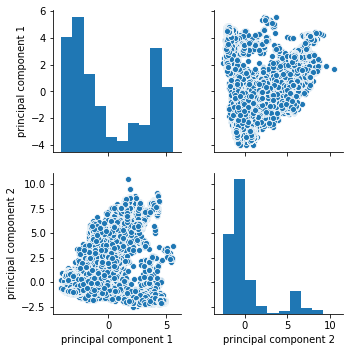

In [50]:
import seaborn as sns
g = sns.pairplot(principalDf)

In [94]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 2)
km.fit(principalDf)
y_kmeans = km.predict(principalDf)

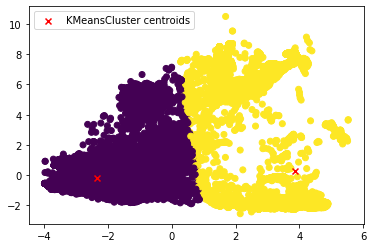

In [126]:
import matplotlib.pyplot as plt

scatter = plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c = y_kmeans, cmap = 'viridis')
centers = np.array(km.cluster_centers_)
plt.scatter(centers[:,0], centers[:,1], marker="x", color='r', label = 'KMeansCluster centroids')
plt.legend(loc="upper left")

In [128]:
# Above we see the result of splitting the dataset into 2 clusters using KMeans Clusters.
# On the left is normal data, on the right is anomaly data.

In [112]:
print(km.cluster_centers_)
print()

[[-2.35572131 -0.17264033]
 [ 3.87200278  0.28376185]]


In [96]:
print('actual percentage of outcome classified as normal', (df.outcome == 'normal').sum() / len(df['outcome']), '%')


actual percentage of outcome classified as normal 0.5345828074269883 %


In [97]:
#check our results by plotting just the "normal" results for the pca data

In [98]:
print(y_kmeans[:10])


[0 0 1 0 0 1 1 1 1 1]


In [99]:
print(df['outcome'].head(10))

0     normal
1     normal
2    neptune
3     normal
4     normal
5    neptune
6    neptune
7    neptune
8    neptune
9    neptune
Name: outcome, dtype: object


In [100]:
values = [(0, 1)[ i[1]['outcome'] == 'normal' ] for i in df.iterrows()]

In [101]:
values[:10]

[1, 1, 0, 1, 1, 0, 0, 0, 0, 0]

In [102]:
len(values)

125973

In [103]:
len(y_kmeans)

125973

In [104]:
match_count = 0
for i in values:
    if i == y_kmeans[i]:
        match_count += 1

In [105]:
print(match_count)

58630


In [106]:
true_ones = 0
for i in values:
    if i == 1:
        true_ones += 1

In [107]:
print(true_ones)

67343
